<a href="https://colab.research.google.com/github/sheikmohdimran/Experiments_2021/blob/main/02_Computer_Vision/Week1_Flowers_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.buymeacoffee.com/sheikmohdimran" target="_blank"><img src="https://cdn.buymeacoffee.com/buttons/default-orange.png" alt="Buy Me A Coffee" height="30" width="120"></a>

You can support my work by buying me a coffee [here](https://www.buymeacoffee.com/sheikmohdimran).

<h1>Case Study: Flowers CNN Classifier</h1>
Flowers dataset (https://www.kaggle.com/alxmamaev/flowers-recognition) 

*Make sure you activate Hardware accelerator in the settings. 
Go to Runtime --> Change runtime type --> Set Hardware Accelerator to GPU*

In [1]:
!pip install fastai==2.4.1 -qqq
!pip install wandb -qqq
!pip install kaggle -qqq
!pip install albumentations --upgrade -qqq

     |████████████████████████████████| 188 kB 7.2 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 1.7 MB 7.4 MB/s 
     |████████████████████████████████| 170 kB 74.1 MB/s 
     |████████████████████████████████| 133 kB 71.4 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 98 kB 6.0 MB/s 
     |████████████████████████████████| 37.1 MB 1.2 MB/s 


In [3]:
#@title Download Dataset
!echo '{"username":"imrandude","key":"3d7a2e65acacc510a2132e9850a50edd"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip -q flowers-recognition.zip


 90% 203M/225M [00:00<00:00, 202MB/s]
100% 225M/225M [00:01<00:00, 219MB/s]


In [6]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn import preprocessing

from pathlib import Path
import pandas as pd

In [7]:
train_data_dir = Path('/content/flowers')

files = train_data_dir.rglob('*.jpg')
input=pd.DataFrame(files,columns =['a'])
input['a']=input['a'].astype(str)
df_train=input['a'].str.split('/',expand=True)
train=input.join(df_train)[['a',3]]
train.columns=('file_path','label')

In [37]:
le = preprocessing.LabelEncoder()
le.fit(train['label'])
train['label_enc']=le.transform(train['label'])
train.head()

,file_path,label,label_enc
0,/content/flowers/daisy/1299501272_59d9da5510_n.jpg,daisy,0
1,/content/flowers/daisy/4837182901_69a6cc782b_n.jpg,daisy,0
2,/content/flowers/daisy/34701078235_4a770d14a1_n.jpg,daisy,0
3,/content/flowers/daisy/2579018590_74359dcf1a_m.jpg,daisy,0
4,/content/flowers/daisy/162362896_99c7d851c8_n.jpg,daisy,0


In [40]:
target_strings = le.inverse_transform(np.arange(5))
target_strings

array(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], dtype=object)

In [9]:
train_df,valid_df= train_test_split(train, test_size=0.20, random_state=42, stratify=train['label'])
train_df.reset_index(inplace = True)
valid_df.reset_index(inplace = True)

# Create Pytorch Dataset with transformations

In [10]:
import wandb
import torch
from torch import nn
from torch import sigmoid
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from copy import deepcopy

from fastai.vision.all import *
from fastai.callback.wandb import *


In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        self.img_labels = data_frame['label_enc']
        self.img_path = data_frame['file_path']
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = cv2.imread(self.img_path.iloc[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[idx].astype(np.long)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [12]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=64, width=64),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=64, width=64),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


In [13]:
train_data = CustomImageDataset(data_frame=train_df,transform=train_transform)
valid_data = CustomImageDataset(data_frame=valid_df,transform=val_transform)

trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
validloader = DataLoader(valid_data, batch_size=256, shuffle=False)

In [14]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

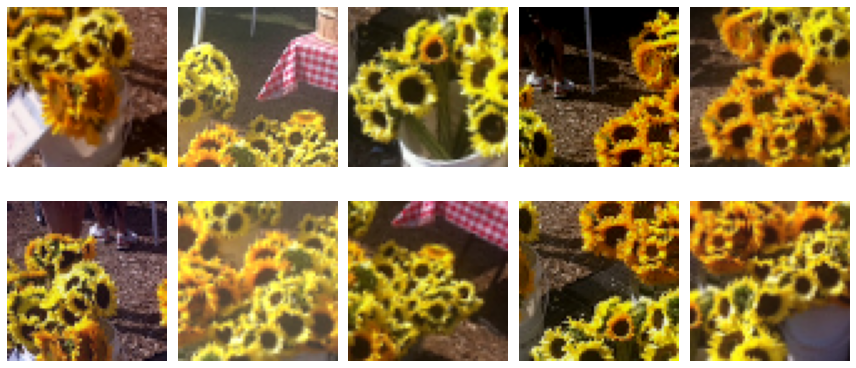

In [15]:
random.seed(42)
visualize_augmentations(train_data)

<h2>Building the CNN Classifier</h2>

### Check input to Linear layer


In [16]:
model = nn.Sequential(
        nn.Conv2d(3, 32, 3, padding = 'same'),
        nn.ReLU(), 
        nn.MaxPool2d(2),
        nn.Conv2d(32, 32, 3, padding = 'same'),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 32, 3, padding = 'same'),
        nn.ReLU(),
        nn.MaxPool2d(2))

In [17]:
def count_input_neuron(model, image_dim):
    return model(torch.rand(1, *(image_dim))).data.view(1, -1).size(1)

In [18]:
count_input_neuron(model,(3,64,64))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


2048

In [19]:
model = nn.Sequential(
        # Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
        nn.Conv2d(3, 32, 3, padding = 'same'),
        nn.ReLU(), 
        
        # Add a Max Pooling layer of size 2X2
        nn.MaxPool2d(2),
        
        # Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
        nn.Conv2d(32, 32, 3, padding = 'same'),
        nn.ReLU(),
        
        # Add a Max Pooling layer again
        nn.MaxPool2d(2),
        
        # Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
        nn.Conv2d(32, 32, 3, padding = 'same'),
        nn.ReLU(),
        
        # Add a Max Pooling layer again
        nn.MaxPool2d(2),
        
        # Flattening the layer before fully connected layers
        nn.Flatten(),
        
        # Adding a fully connected layer with 512 neurons
        nn.Linear(2048, 512),
        nn.ReLU(),
        
        # Adding dropout with probability 0.5
        nn.Dropout(p=0.5),
        
        # Adding a fully connected layer with 128 neurons
        nn.Linear(512, 128),
        nn.ReLU(),
        
        # The final output layer with 5 neuron to predict the categorical classifcation
        nn.Linear(128, 5),
    )


In [20]:
data = DataLoaders(trainloader, validloader)
learn = Learner(data, 
                model, 
                loss_func=CrossEntropyLossFlat(), 
                opt_func=Adam, 
                metrics=accuracy)

In [21]:
learn.fit(20)

epoch,train_loss,valid_loss,accuracy,time
0,1.400833,1.279772,0.458333,00:24
1,1.311741,1.197048,0.483796,00:24
2,1.266079,1.401232,0.384259,00:24
3,1.233898,1.129494,0.490741,00:24
4,1.166822,1.016700,0.589120,00:24
5,1.135843,0.973694,0.586806,00:24
6,1.101502,0.992886,0.603009,00:25
7,1.075322,0.945221,0.621528,00:26
8,1.094832,0.913913,0.634259,00:25
9,1.053726,0.921606,0.630787,00:25


In [49]:
learn.save('myModel', with_opt=False)

Path('models/myModel.pth')

# Check prediction

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict(model, dataloader, n_class, device):
    model.eval()
    model.to(device)
    preds = np.zeros([0, n_class])
    for data, _ in dataloader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data).detach()
        y_pred = y_pred.cpu().numpy()
        preds = np.concatenate([preds, y_pred])
    return preds

In [23]:
valid_preds = predict(model, validloader, n_class=5, device=device)

In [24]:
pred_label = np.argmax(valid_preds, axis=1)
true_label=valid_df['label_enc'].to_numpy()

In [48]:
test_acc = skm.accuracy_score(true_label, pred_label)

print(f'test acc: {test_acc}')
print('\nConfusion Matrix: \n')
print(skm.confusion_matrix(true_label, pred_label))
print('\nClassification Report:\n')
print(skm.classification_report(true_label, pred_label, target_names=target_strings))

test acc: 0.6759259259259259 


Confusion Matrix: 

[[110   9  11  14   9]
 [ 19 143   9  28  11]
 [ 18   3  81   2  53]
 [  4  22   2 113   6]
 [  6   7  41   6 137]]

Classification Report:

              precision    recall  f1-score   support

       daisy       0.70      0.72      0.71       153
   dandelion       0.78      0.68      0.73       210
        rose       0.56      0.52      0.54       157
   sunflower       0.69      0.77      0.73       147
       tulip       0.63      0.70      0.66       197

    accuracy                           0.68       864
   macro avg       0.67      0.68      0.67       864
weighted avg       0.68      0.68      0.68       864



### Additional Reading:
* https://discuss.pytorch.org/t/help-convert-tensorflow-convolutional-layer-into-pytorch/92579
* https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
* https://discuss.pytorch.org/t/linear-layer-input-neurons-number-calculation-after-conv2d/28659